In [162]:
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import requests
# import haversine as hs

pd.set_option('display.max_colwidth', 500)
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

import scipy as sp
import scipy.stats as sps
from scipy.stats import pearsonr

import statsmodels.api as sms
import statsmodels.formula.api as smf

### I. DATA COLLECTION AND CLEANING

#### 1. Schools

In [172]:
parks = []
for line in open('data/parks.json', encoding='latin-1'):
    parks.append(json.loads(line))

In [2]:
# schools_attributed = []
# for line in open('data/schools_school_to_buildings.json'):
#     schools_attributed.append(json.loads(line))
    
# name = []
# rating = []
# buildings = []

# for i in schools_attributed:
#     name.append(i['name'])
#     rating.append(i['rating'])
#     buildings.append(i['buildings'])
    
# schools_attr = pd.DataFrame(list(zip(name, rating, buildings)),
#               columns=['name','rating','buildings'])

In [3]:
schools = []
for line in open('data/schools_school_to_address.json'):
    schools.append(json.loads(line))

In [4]:
schools[1]['name']

'Лицей НИУ ВШЭ'

In [5]:
name = []
lon_list = []
lat_list = []
addresses = []
rating = []
for i in schools:
    name.append(i['name'])
    lon_list.append(i['lon_list'])
    lat_list.append(i['lat_list'])
    addresses.append(i['addresses'])
    rating.append(i['rating'])

schools = pd.DataFrame(list(zip(name, lon_list, lat_list, addresses, rating)),
              columns=['name','lon_list','lat_list', 'addresses', 'rating'])

In [6]:
print(schools.shape)
schools.head(1)

(383, 5)


,name,lon_list,lat_list,addresses,rating
0,Школа № 1535,"[37.564907, 37.562056]","[55.726041, 55.730911]","[Россия, Москва, Усачёва улица, 50, Россия, Москва, Малый Саввинский переулок, 8]",1


In [7]:
r = list(range(1,400,1))
rat = pd.DataFrame(data=r, columns = ['rat'])

In [8]:
merged = schools.merge(rat, how='right', left_on = "rating", right_on = 'rat')
print(f"{len(merged[merged.rating.isna()])} of rating items are not schools, but rather professional colleges and thus are excluded")

16 of rating items are not schools, but rather professional colleges and thus are excluded


In [9]:
def flatten_by_column(col, col_name):
    flat_df = pd.DataFrame([[i, x]
                       for i, y in col.apply(list).iteritems()
                       for x in y], columns=['I', col_name])
    
    flat_df = flat_df.set_index('I')
    return flat_df

lat_flat = flatten_by_column(schools['lat_list'], "lat")
lon_flat = flatten_by_column(schools['lon_list'], "lon")
addr_flat = flatten_by_column(schools['addresses'], "address")

In [10]:
schools_flattened = schools[['name', 'rating']].merge(lat_flat, left_index=True, right_index=True)

schools_final = pd.concat([schools_flattened, lon_flat, addr_flat], axis=1)
schools_final.reset_index(drop=True, inplace=True)

In [11]:
schools_final.head(2)

,name,rating,lat,lon,address
0,Школа № 1535,1,55.726041,37.564907,"Россия, Москва, Усачёва улица, 50"
1,Школа № 1535,1,55.730911,37.562056,"Россия, Москва, Малый Саввинский переулок, 8"


In [169]:
schools_final[['name','rating','lat','lon','idx','address']].to_csv('schools.tsv', sep='\t', index=False)

In [12]:
gdf = gpd.GeoDataFrame(schools_final, 
      geometry=gpd.points_from_xy(schools_final['lon'], schools_final['lat'], crs='epsg:4326'))

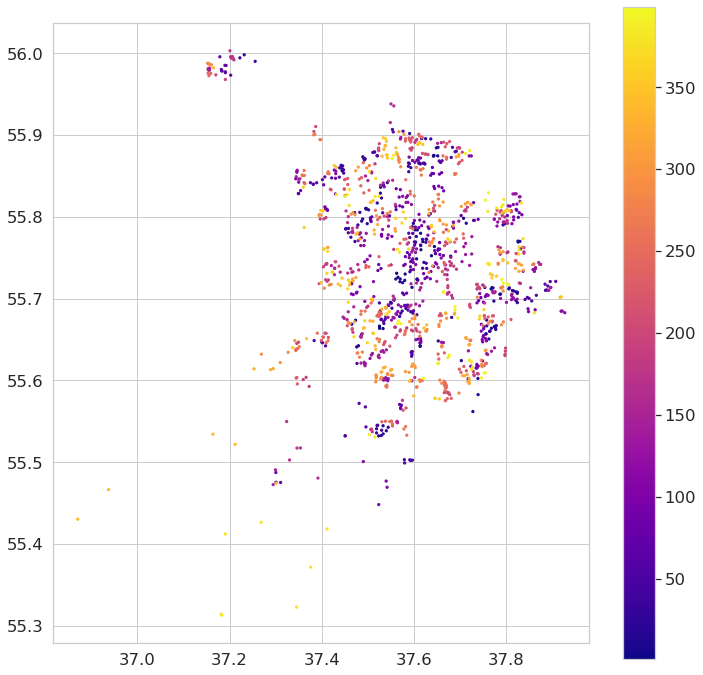

In [13]:
gdf.plot(column='rating', cmap='plasma', figsize=(12,12), legend= True, markersize=5);

#### 2. Housing prices

In [70]:
prices = pd.read_csv('data/msc_housing_offers_from_2019.csv', sep='\t')

In [71]:
print(prices.shape)
prices.head(2)

(443914, 33)


,building_series_id,total_images,parking,is_premoderation,last_price,total_area,first_day_exposition,rooms,ceiling_height,last_day_exposition,...,offer_id,category_type,is_new_flat,building_type,price_period,balcony,flattypeint,renovation,latitude,longitude
0,NaN,6,NaN,False,14495700,68.699997,2019-01-01T00:00:00+03:00,2,NaN,2019-05-15T00:00:00+03:00,...,4834713321651664542,2,True,2.0,100,NaN,3.0,NaN,55.770851,37.564167
1,NaN,6,NaN,False,14868000,70.800003,2019-01-01T00:00:00+03:00,2,NaN,2019-05-15T00:00:00+03:00,...,4834713321651664508,2,True,2.0,100,NaN,3.0,NaN,55.770851,37.564167


In [72]:
prices.is_new_flat.value_counts(dropna=False)

False    382498
True      61416
Name: is_new_flat, dtype: int64

In [73]:
list(prices.columns)

['building_series_id',
 'total_images',
 'parking',
 'is_premoderation',
 'last_price',
 'total_area',
 'first_day_exposition',
 'rooms',
 'ceiling_height',
 'last_day_exposition',
 'floors_total',
 'living_area',
 'floor',
 'cluster_id',
 'is_apartment',
 'building_id',
 'studio',
 'offer_type',
 'first_price',
 'unified_address',
 'area',
 'open_plan',
 'kitchen_area',
 'offer_id',
 'category_type',
 'is_new_flat',
 'building_type',
 'price_period',
 'balcony',
 'flattypeint',
 'renovation',
 'latitude',
 'longitude']

In [74]:
prices.is_apartment.value_counts(dropna=False, normalize=True)

NaN      0.714634
False    0.251596
True     0.033770
Name: is_apartment, dtype: float64

In [75]:
# 'Apartment' is a special law status in Russian real estate for non-residential units like lofts etc. 
# It is not against the law to live in them, but there are some legislative peculiarities associated with them.
# We drop them because they are out of focus of this research

prices.drop(prices[prices.is_apartment==True].index, inplace=True)

In [76]:
di = {1: "Sale", 2: "Rent"}
prices['offer_type'] = prices['offer_type'].map(di)
prices.offer_type.value_counts()

Sale    260565
Rent    168358
Name: offer_type, dtype: int64

In [77]:
prices = prices[prices.offer_type=='Sale']

In [78]:
di = {1: "BRICK", 2: "MONOLIT", 3: "MONOLIT_BRICK", 4: "PANEL", 5: "WOOD", 6: "BLOCK", 7: "METAL", 8: "FERROCONCRETE"}

prices['building_type'] = prices['building_type'].map(di)
prices.building_type.value_counts(dropna=False)

PANEL            102283
MONOLIT           66113
BRICK             53219
NaN               22204
BLOCK             10708
MONOLIT_BRICK      5962
WOOD                 76
Name: building_type, dtype: int64

In [79]:
prices.drop(columns=['building_series_id','total_images','parking','is_premoderation','total_area', 'ceiling_height','floors_total','living_area',
                     'floor', 'cluster_id','building_id','building_type','studio', 'open_plan','kitchen_area', 'balcony','renovation',
                     'category_type', 'price_period','is_apartment','flattypeint'
                    ], inplace=True)

prices['last_day_exposition'] = pd.to_datetime(prices.last_day_exposition).dt.date
prices['first_day_exposition'] = pd.to_datetime(prices.first_day_exposition).dt.date

In [81]:
prices = prices[['offer_id', 'offer_type', 'first_day_exposition', 'last_day_exposition','first_price', 'last_price',
                 'rooms', 'area', 'unified_address', 'is_new_flat', 'latitude', 'longitude']]

In [82]:
print(prices.shape)
prices.head(2)

(260565, 12)


,offer_id,offer_type,first_day_exposition,last_day_exposition,first_price,last_price,rooms,area,unified_address,is_new_flat,latitude,longitude
0,4834713321651664542,Sale,2019-01-01,2019-05-15,14495700,14495700,2,68.699997,"Россия, Москва, Ходынская улица, вл2кБ",True,55.770851,37.564167
1,4834713321651664508,Sale,2019-01-01,2019-05-15,14868000,14868000,2,70.800003,"Россия, Москва, Ходынская улица, вл2кБ",True,55.770851,37.564167


In [83]:
prices.isna().sum()

offer_id                    0
offer_type                  0
first_day_exposition        0
last_day_exposition     29655
first_price                 0
last_price                  0
rooms                       0
area                        0
unified_address             0
is_new_flat                 0
latitude                38669
longitude               38669
dtype: int64

In [84]:
prices = prices[~prices.last_day_exposition.isna()]

In [85]:
#The address is "Russia, Moscow" which is not a specific building
prices.drop(prices[prices.unified_address=="Россия, Москва"].index, inplace=True)

In [86]:
#Drop New Moscow – administrative part of Moscow which is deographically too distant
prices = prices[(~prices.unified_address.str.contains("Зеленоград"))&
                   (~prices.unified_address.str.contains("Троицк"))&
                    (~prices.unified_address.str.contains("посёлок"))&
                    (~prices.unified_address.str.contains("поселение"))&
                   (~prices.unified_address.str.contains("поселок"))]

In [87]:
prices.shape

(208092, 12)

### Data distribution

In [88]:
prices['sqm_price'] = round(prices['last_price']/prices['area'])
prices['area'] = round(prices['area'])

In [89]:
prices.head(2)

,offer_id,offer_type,first_day_exposition,last_day_exposition,first_price,last_price,rooms,area,unified_address,is_new_flat,latitude,longitude,sqm_price
0,4834713321651664542,Sale,2019-01-01,2019-05-15,14495700,14495700,2,69.0,"Россия, Москва, Ходынская улица, вл2кБ",True,55.770851,37.564167,211000.0
1,4834713321651664508,Sale,2019-01-01,2019-05-15,14868000,14868000,2,71.0,"Россия, Москва, Ходынская улица, вл2кБ",True,55.770851,37.564167,210000.0


In [90]:
perc_01 = prices['sqm_price'].quantile(0.01)
perc_99 = prices['sqm_price'].quantile(0.99)

prices_clean = prices[prices['sqm_price'] > perc_01]
prices_clean = prices_clean[prices_clean['sqm_price'] < perc_99]

In [135]:
prices_clean.shape

(201920, 21)

In [136]:
min1 = prices_clean['sqm_price'].min()
max1 = prices_clean['sqm_price'].max()

median1 = prices_clean['sqm_price'].median()

std1 = prices_clean['sqm_price'].std()

print(min1, max1, median1, std1)
prices_clean['sqm_price'].describe()

112518.0 964580.0 204545.0 110885.39287986295


count    201920.00000
mean     237337.62965
std      110885.39288
min      112518.00000
25%      174497.00000
50%      204545.00000
75%      258751.25000
max      964580.00000
Name: sqm_price, dtype: float64

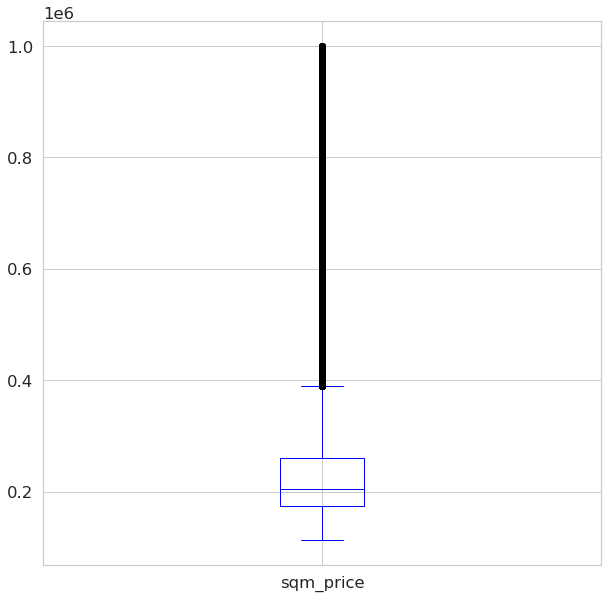

In [94]:
prices_clean.boxplot(column=['sqm_price'], color='blue', figsize=[10,10]); 

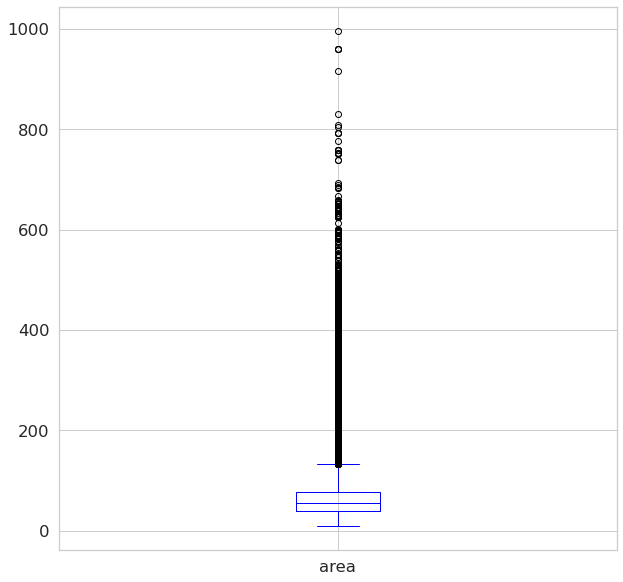

In [95]:
prices_clean.boxplot(column=['area'], color='blue', figsize=[10,10]);

In [134]:
perc_99 = prices['area'].quantile(0.99)
prices_clean = prices_clean[prices_clean['area'] < perc_99]

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


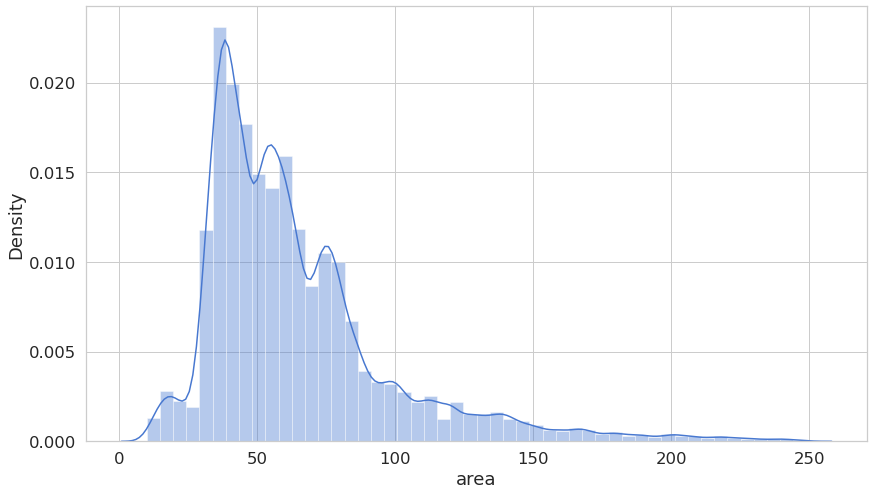

In [144]:
sns.distplot(prices_clean['area']);

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


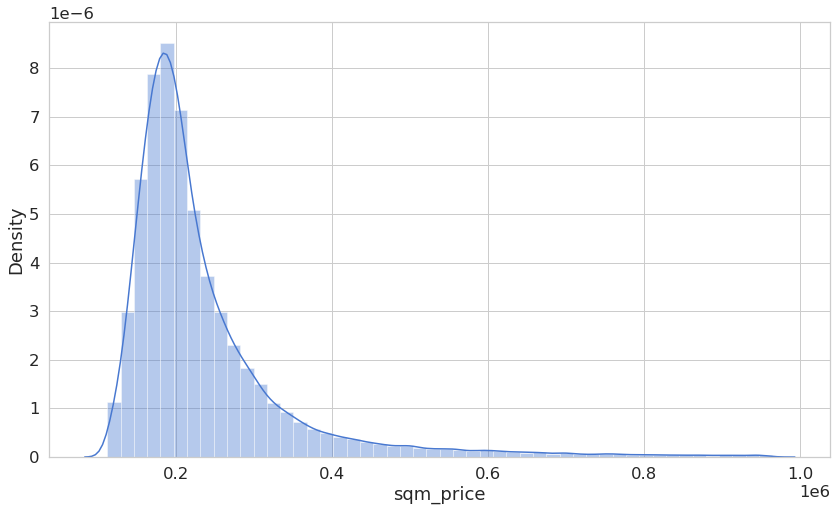

In [139]:
sns.distplot(prices_clean['sqm_price']);

In [176]:
prices_clean['ln_price'] =np.log(prices_clean['sqm_price'])

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


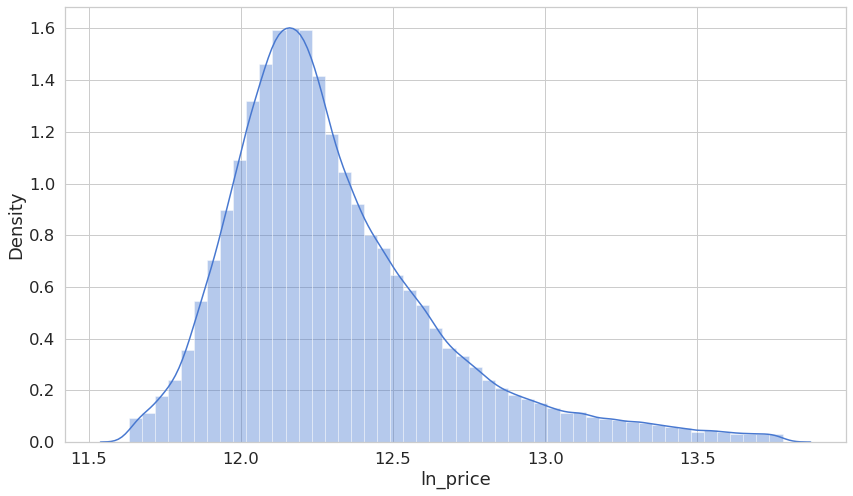

In [177]:
sns.distplot(prices_clean['ln_price']);

## 3. Geocoding records without coordinates

In [100]:
prices_clean.isna().sum()

offer_id                    0
offer_type                  0
first_day_exposition        0
last_day_exposition         0
first_price                 0
last_price                  0
rooms                       0
area                        0
unified_address             0
is_new_flat                 0
latitude                23099
longitude               23099
sqm_price                   0
log_price                   0
dtype: int64

In [46]:
not_geocoded = pd.DataFrame(prices_clean[prices_clean.latitude.isna()]['unified_address'].unique(), columns=['addr'])
not_geocoded.shape

(2540, 1)

In [47]:
not_geocoded['url_addr'] = not_geocoded['addr'].str.replace(" ", "+").str.replace(",","")

In [48]:
not_geocoded_1 = not_geocoded[:1258]
not_geocoded_2 = not_geocoded[1260:]

In [50]:
# url = "https://geocode-maps.yandex.ru/1.x/?apikey=0d8ab1f5-f5f1-443b-b9a5-dd839be4db59&format=json&geocode="
# url = "https://geocode-maps.yandex.ru/1.x/?apikey=c6cd58aa-a304-43fb-ba3b-ab46d32ef39f&format=json&geocode="
# url = "https://geocode-maps.yandex.ru/1.x/?apikey=cc6b7d57-b2aa-4bb0-86f0-90eb6b242355&format=json&geocode="
url = "https://geocode-maps.yandex.ru/1.x/?apikey=c8679a9d-e896-4115-ac6f-04524ce7ca57&format=json&geocode="


def geocode_addresses(addr):
    r = requests.get(url + addr)
    response = r.text
    json_data = json.loads(response)
    coordinates = json_data['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
    lat = coordinates.split(' ')[1]
    lon = coordinates.split(' ')[0]
    return lat, lon

addr = []
lat = []
lon = []

for index, row in not_geocoded_2.iterrows():
    coord = geocode_addresses(row['url_addr'])
    lat.append(coord[0])
    lon.append(coord[1])
    addr.append(row['addr'])
    print(f"{index} done")

geocoded_results_2 = pd.DataFrame(list(zip(addr, lat, lon)), 
                                  columns=['addr','lat','lon'])

In [ ]:
geocoded_results = pd.concat([geocoded_results_1, geocoded_results_2], axis=0)

In [101]:
# geocoded_results.to_csv('geocoded_results.csv', index=False, sep='\t')
geocoded_results = pd.read_csv('geocoded_results.csv', sep='\t')

In [ ]:
geocoded_results.head(2)

In [53]:
gdf = gpd.GeoDataFrame(geocoded_results, 
      geometry=gpd.points_from_xy(geocoded_results['lon'], geocoded_results['lat'], crs='epsg:4326'))

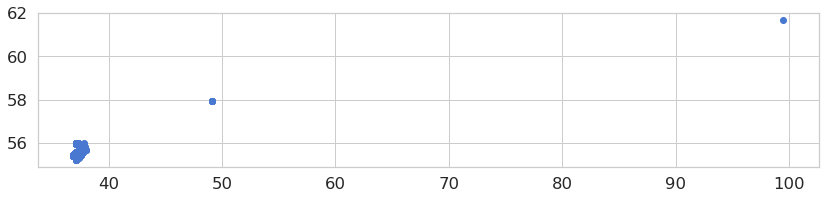

In [54]:
gdf.plot();

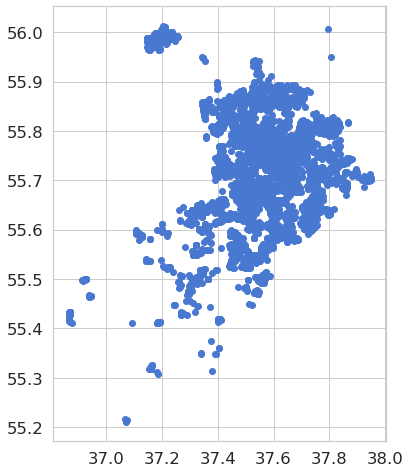

In [55]:
gdf[gdf['lon'] < 40].plot();

In [102]:
prices_clean = prices_clean.merge(geocoded_results, how='left', left_on='unified_address', right_on='addr')

In [103]:
prices_clean['latitude'] = prices_clean['latitude'].fillna(prices_clean['lat'])
prices_clean['longitude'] = prices_clean['longitude'].fillna(prices_clean['lon'])

In [104]:
prices_clean.drop(columns=['addr','lat','lon'], inplace=True)

In [105]:
prices_clean.drop(prices_clean[prices_clean.longitude >40].index, inplace=True)

In [106]:
prices_clean.isna().sum()

offer_id                0
offer_type              0
first_day_exposition    0
last_day_exposition     0
first_price             0
last_price              0
rooms                   0
area                    0
unified_address         0
is_new_flat             0
latitude                2
longitude               2
sqm_price               0
log_price               0
dtype: int64

In [107]:
prices_clean['latitude'] = prices_clean['latitude'].astype(float)
prices_clean['longitude'] = prices_clean['longitude'].astype(float)

In [ ]:
# df_sell =df1.groupby(['unified_address'])['sqm_price'].mean().reset_index()
# house_coord = prices.groupby(['unified_address'])[['latitude', 'longitude']].mean().reset_index()

In [108]:
prices_clean['coor'] = list(zip(prices_clean.latitude, prices_clean.longitude))
schools_final['coor'] = list(zip(schools_final.lat, schools_final.lon))

# prices_clean['coor'] = zip(prices_clean['latitude'], prices_clean['longitude'])
# schools_final['school_coor'] = zip(schools_final['lat'], schools_final['lon'])

In [109]:
prices_clean.to_csv('data/prices_clean.csv', sep='\t', index=False)
# prices_clean=pd.read_csv('data/prices_clean.csv', sep='\t')

In [67]:
# schools_final['idx'] = range(1, len(schools_final) + 1)
# schools_final.to_csv('data/schools_final.csv', sep='\t', index=False)

In [ ]:
schools_final=pd.read_csv('data/schools_final.csv', sep='\t')

### Find nearest school and its rating

In [ ]:
def distance_from(loc1,loc2): 
#     print(loc1)
#     print(loc2)
    dist=hs.haversine(loc1,loc2)
    return round(dist,2)

In [ ]:
unique_addr = prices_clean.groupby(['unified_address'])[['latitude', 'longitude']].mean().reset_index()
unique_addr['coor'] = list(zip(unique_addr.latitude, prices_clean.longitude))

In [ ]:
unique_addr.shape

In [ ]:
start = time.time()

for index,row in schools_final.iterrows():
    unique_addr[row.idx]=unique_addr['coor'].apply(lambda x: distance_from(row.coor,x))

end = time.time()
print(f"Total time: {end - start} seconds")

In [ ]:
unique_addr.head(2)

In [ ]:
unique_addr.to_csv('unique_addr.csv', sep='\t', index=False)

In [ ]:
start = time.time()

for index,row in schools_final.iterrows():
    prices_clean[row.idx]=prices_clean['coor'].apply(lambda x: distance_from(row.coor,x))

end = time.time()
print(f"Total time: {end - start} seconds")

In [ ]:
prices_clean['school_idx'] = prices_clean.iloc[:,14:].idxmin(axis=1)
prices_clean['school_distance'] = prices_clean.iloc[:,14:-1].min(axis=1)
prices_clean.drop(prices_clean.iloc[:,14:-2],axis=1,inplace=True)

In [ ]:
#distance to city center
d = {'lat': [55.753229], 'lon': [37.622503], 'center':['center']}
df_center = pd.DataFrame(data=d)
df_center['coor'] = list(zip(df_center.lat, df_center.lon))

for index,row in df_center.iterrows():
    prices_clean[row.center]=prices_clean['coor'].apply(lambda x: distance_from(row.coor,x))

In [117]:
prices_clean.to_csv('data/prices_clean_with_school_idx.csv', index=False, sep='\t')
prices_clean = pd.read_csv('data/prices_clean_with_school_idx.csv', sep='\t')

In [118]:
prices_clean = prices_clean.merge(schools_final[['idx','rating']], how='left', left_on='school_idx', right_on='idx')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


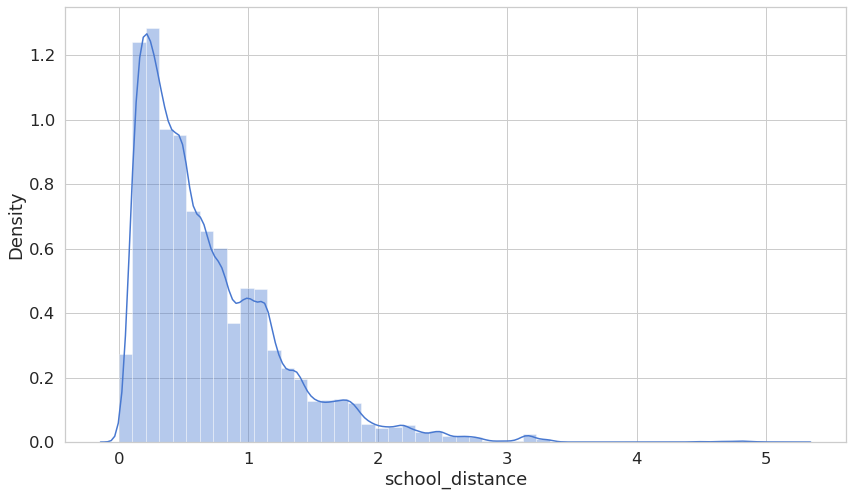

In [119]:
sns.distplot(prices_clean['school_distance']);

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


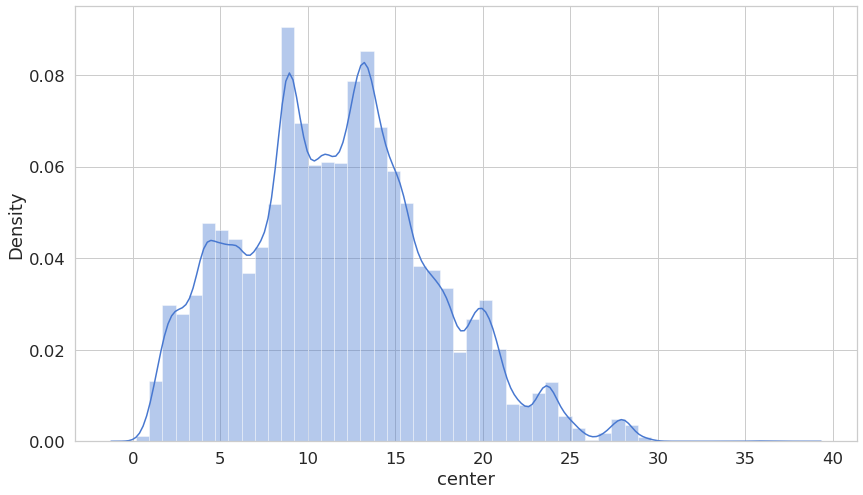

In [120]:
sns.distplot(prices_clean['center']);

In [146]:
def create_dummy(df):
    if df['school_distance']>0.5:
        return 1
    else:
        return 0

prices_clean['school_is_nearby'] = prices_clean.apply(create_dummy, axis=1)

In [147]:
prices_clean.school_is_nearby.value_counts()
prices_clean.school_is_nearby.value_counts(normalize=True)

1    0.524807
0    0.475193
Name: school_is_nearby, dtype: float64

In [148]:
prices_clean['is_new_flat'] = prices_clean['is_new_flat'].map({True:1,False:0})

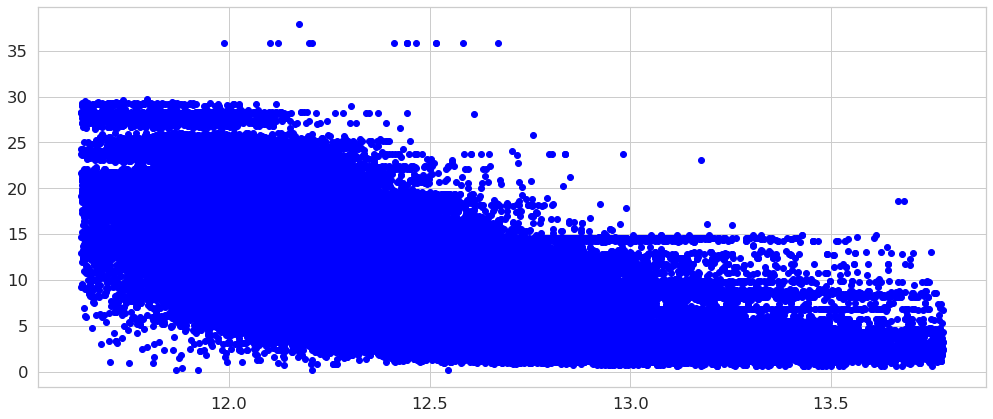

In [149]:
f, ax = plt.subplots(figsize=(17, 7))
plt.scatter(prices_clean['log_price'], prices_clean['center'], color='blue')
# plt.xlabel('Total budgets per capita')
# plt.ylabel('Rate of obesity change')
plt.show()

In [152]:
corr, _ = pearsonr(prices_clean['sqm_price'], prices_clean['center'])
round(corr, 3)

-0.55

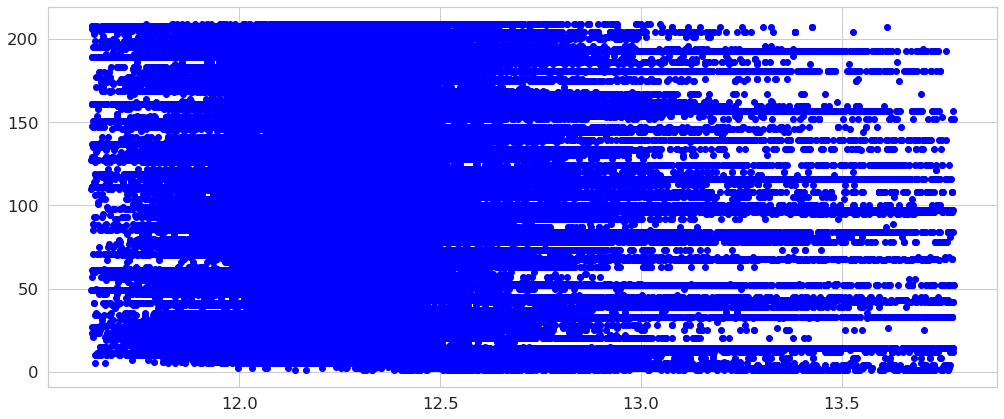

In [150]:
f, ax = plt.subplots(figsize=(17, 7))
plt.scatter(prices_clean['log_price'], prices_clean['rating'], color='blue')
# plt.xlabel('Total budgets per capita')
# plt.ylabel('Rate of obesity change')
plt.show()

In [153]:
corr, _ = pearsonr(prices_clean['log_price'], prices_clean['rating'])
round(corr, 3)

-0.052

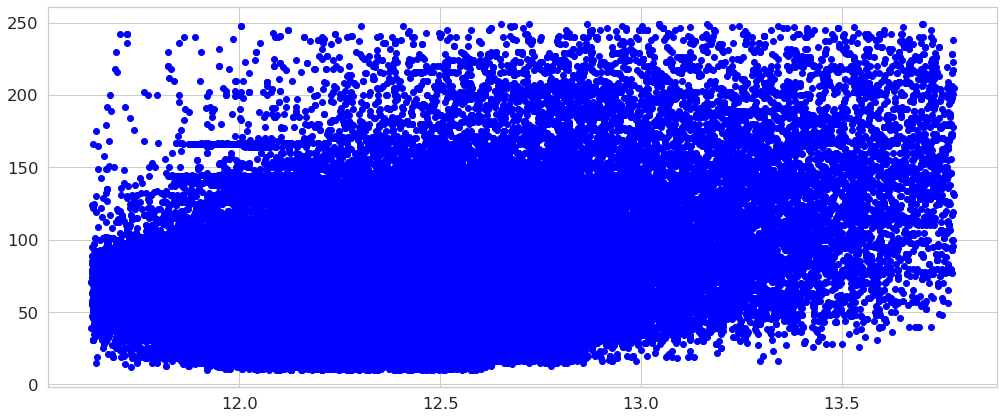

In [154]:
f, ax = plt.subplots(figsize=(17, 7))
plt.scatter(prices_clean['log_price'], prices_clean['area'], color='blue')
# plt.xlabel('Total budgets per capita')
# plt.ylabel('Rate of obesity change')
plt.show()

In [155]:
corr, _ = pearsonr(prices_clean['log_price'], prices_clean['area'])
round(corr, 3)

0.407

### Multiple linear regression

In [157]:
data = prices_clean[['offer_id', 'area', 'rating', 'school_is_nearby', 'is_new_flat', 'center', 'log_price', 'last_price', 'sqm_price']]

In [158]:
housing_model = smf.ols(formula='log_price ~ area + rating + C(school_is_nearby) + C(is_new_flat) + center',
                                   data=data).fit()

print(housing_model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                 3.503e+04
Date:                Sat, 23 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:59:51   Log-Likelihood:                -13965.
No. Observations:              201920   AIC:                         2.794e+04
Df Residuals:                  201914   BIC:                         2.800e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

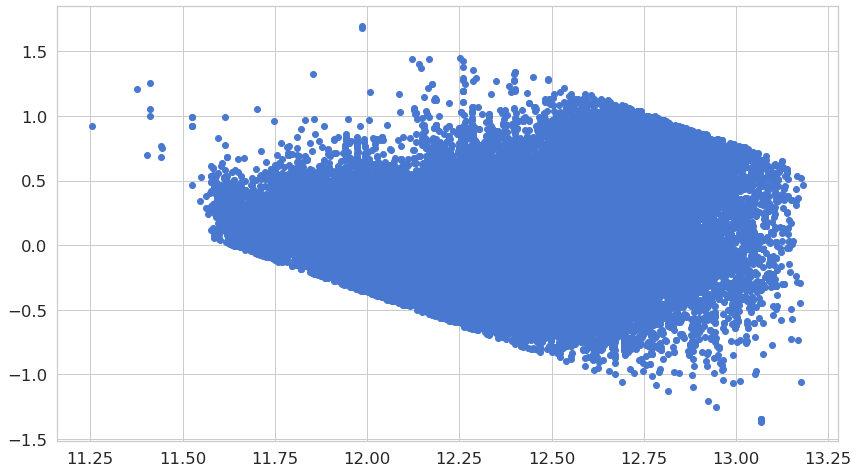

In [174]:
plt.scatter(housing_model.fittedvalues, housing_model.resid)
# plt.xlabel('Fitted obesity cases')
# plt.ylabel('Residual')
# plt.title('Residual vs. Fitted Plot of obesity')
plt.show()

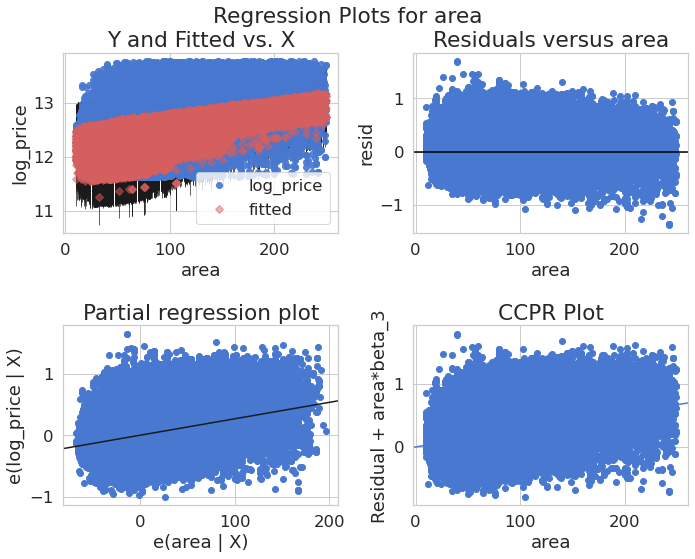

In [165]:
# produce regression plots
fig = plt.figure(figsize=(10,8))
fig = sm.graphics.plot_regress_exog(housing_model, 'area', fig=fig)

In [178]:
independent_var = data.loc[:, ['area','rating','center']]

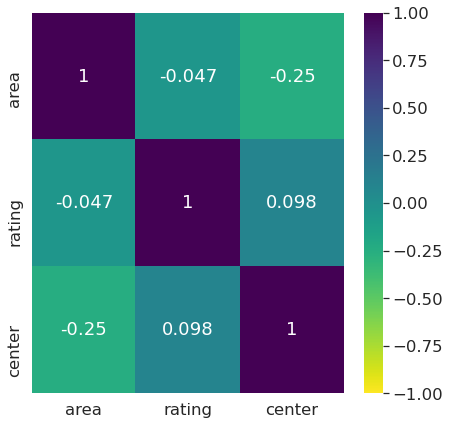

In [179]:
f, ax = plt.subplots(figsize=(7, 7))

corr_matrix = independent_var.corr()

sns.heatmap(corr_matrix,
            cmap='viridis_r',
            annot = True,
            vmin = -1,
            vmax = 1
           );